# Helpful score prediction

In [1]:
% matplotlib inline

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from operator import itemgetter

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

/home/m.victor.le/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load video games review dataframe

In [2]:
with open('pickle/video_games.pkl', 'rb') as input:
    video_games = pickle.load(input)

In [23]:
# Get only the reviews with a helpful rate
video_games = video_games[video_games.helpfulRate >= 0]
video_games = video_games[video_games.helpfulCount >= 10]

# Create a columns that will be use as a label for our binary classification
video_games['helpfulOrNot'] = video_games['helpfulRate'].apply(lambda x: 'helpful' if x > 0.5 else 'notHelpful')
video_games['helpfulOrNotOrNeutral'] = video_games.helpfulRate.map(lambda x: 'notHelpful' if x < 0.33 else 'neutral' if x < 0.66 else 'helpful')

# Add features
video_games['exclamationCount'] = video_games['reviewText'].str.count('!') + video_games['summary'].str.count('!')
video_games['questionCount'] = video_games['reviewText'].str.count('\?') + video_games['summary'].str.count('\?')
video_games['threeDotsCount'] = video_games['reviewText'].str.count('\.\.\.') + video_games['summary'].str.count('\.\.\.')
video_games['uppercaseCount'] = video_games['reviewText'].str.count('[A-Z]') + video_games['summary'].str.count('[A-Z]')


In [4]:
video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   
           AN3YYDZAS3O1Y         5   
           AQTC623NCESZW         1   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   
           AN3YYDZAS3O1Y   Loved playing Dirt 2 and I thought the graphic...   
           AQTC623NCESZW   I can't tell you what a piece of dog**** this ...   

                                           reviewerName  \
asin       reviewerID                                     
0700099867 A2HD75EMZR8QLN                           123   
           A1DLMTOTHQ4AST                      ampgreen   
           A361M14PU2GUEG  Angry Ryan "Ryan A. Forrest"   
           AN3YYDZAS3O1Y                            Bob   
           AQTC623NCESZW                  Chesty Puller   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   
           AN3YYDZAS3O1Y       A step up from Dirt 2 and that is terrific!   
           AQTC623NCESZW             Crash 3 is correct name AKA Microsoft   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   
           AN3YYDZAS3O1Y  2011-08-14     0.846154            13  6629   
           AQTC623NCESZW  2012-11-24     0.250000             4  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   
           AN3YYDZAS3O1Y   Dirt 3 is a popular rally racing game for Play...   
           AQTC623NCESZW   Dirt 3 is a popular rally racing game for Play...   

                            price       ...       brand reviewLength  \
asin       reviewerID                   ...                            
0700099867 A2HD75EMZR8QLN  246.63       ...                      779   
           A1DLMTOTHQ4AST  246.63       ...                     3489   
           A361M14PU2GUEG  246.63       ...                      294   
           AN3YYDZAS3O1Y   246.63       ...                      431   
           AQTC623NCESZW   246.63       ...                      728   

                           summaryLength  reviewerNameLength  helpfulOrNot  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN             40                 3.0       helpful   
           A1DLMTOTHQ4AST             47                 8.0       helpful   
           A361M14PU2GUEG              6                28.0       helpful   
           AN3YYDZAS3O1Y              43                 3.0       helpful   
           AQTC623NCESZW              37                13.0    notHelpful   

                          helpfulOrNotOrNeutral exclamationCount  \
asin       reviewerID                        

## Pipeline classication

### Text preprocessing

In [29]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [30]:
print('Original review text:')
print(video_games.iloc[19].reviewText)
print('Preprocessed text:')
print(NLTKPreprocessor().transform([video_games.iloc[19].reviewText])[0])



Original review text:
Words really can describe how wonderful this game is. The first thing you will notice is the incredible graphics (note: a 3D card is not required!.) Everything is drawn in great detail right down to character traits and facial expressions (who would have thought a fleshless person would be so good with expressions.) The story is also very entertaining and added with the graphics, it makes this a very absorbing adventure. This is one of the few games that I can't say anything negative about. This is a must have!
Preprocessed text:
['word', 'really', 'describe', 'wonderful', 'game', 'first', 'thing', 'notice', 'incredible', 'graphic', 'note', '3d', 'card', 'require', 'everything', 'draw', 'great', 'detail', 'right', 'character', 'trait', 'facial', 'expression', 'would', 'think', 'fleshless', 'person', 'would', 'good', 'expression', 'story', 'also', 'entertaining', 'add', 'graphic', 'make', 'absorbing', 'adventure', 'one', 'game', 'say', 'anything', 'negative', 'must

### Create pipeline

In [69]:
from sklearn.svm import SVC

class MultipleItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        if not isinstance(data_dict[:, self.keys][0], str):
            return np.array(list(data_dict[:, self.keys])).reshape(len(data_dict), 1)
        return data_dict[:, self.keys]
    
class TextLength(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text)} for text in posts]

def identity(x): 
    return x

def create_pipeline(classifier=SGDClassifier):
    if isinstance(classifier, type):
        classifier = classifier()

    model = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('summary', Pipeline([
                    ('selector', MultipleItemSelector(keys=0)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorize', w2v_vectorizer),
#                     ('vectorizer', TfidfVectorizer(
#                         tokenizer=identity, preprocessor=None, lowercase=False
#                     )),
#                     ('best', TruncatedSVD(n_components=50)), # LSA
                ])),
                ('reviewText', Pipeline([
                    ('selector', MultipleItemSelector(keys=1)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorize', w2v_vectorizer),

#                     ('vectorizer', TfidfVectorizer(
#                         tokenizer=identity, preprocessor=None, lowercase=False
#                     )),
#                     ('best', TruncatedSVD(n_components=100)), # LSA
                ])),
                ('reviewText_length', Pipeline([
                    ('selector', MultipleItemSelector(keys=2)),
                ])),
                ('overall', Pipeline([
                    ('selector', MultipleItemSelector(keys=3)),
                ])),
                ('exclamationCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=4)),
                ])),
                ('questionCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=5)),
                ])),
                ('threeDotsCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=6)),
                ])),
                ('uppercaseCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=7)),
                ])),
                
            ],
            transformer_weights={
                'summary': 1.0,
                'reviewText': 1.0,
                'reviewText_length': 1.0,
                'overall': 1.0,
                'exclamationCount': 0.0,
                'questionCount': 1.0,
                'threeDotsCount': 1.0,
                'uppercaseCount': 1.0,
            },
        )),

        ('classifier', classifier),
    ])
        

    return model

### Test on playstation reviews

In [25]:
ps_reviews = video_games.loc['B00BGA9WK2']
len(ps_reviews)

195

In [26]:
asins = ['B000810NAS', 'B004V7W3EO', 'B000WJOYAQ', 'B000J55YSE', 'B00001ZT4C', 'B002JZ7STU', 'B00025LDKO', 'B0007TYMLW', 'B00003IEL1', 'B000IK3XJW', 'B00HFTOTI8', 'B0046LVG3Y', 'B001514JP0', 'B000760OV2', 'B000GDAZXI', 'B00005JDNJ', 'B0000ZUA78', 'B00004UE0I', 'B000LO68JC', 'B000IO2HNQ', 'B00079MUXE', 'B000077W0H', 'B00004WI4B', 'B00HFU41OY', 'B000059XP2', 'B000RJTZTG', 'B001SN6YGC', 'B004BDBSQW', 'B0009HK2MK', 'B000056EZG', 'B009GFBRZ2', 'B0061ABD90', 'B005A2JVN0', 'B00002S7YP', 'B000IWQUO0', 'B00162L5OG', '1557556741', 'B000RS5C4E', 'B004KIV29G', 'B0012DPHKW', 'B0001PKEXM', 'B0017WKITS', 'B00079MVHY', 'B001QINBBK', 'B000NJFMR4', 'B000WA8V3Q', 'B000GJWGI4', 'B000KHIRCG', 'B000P59QE6', 'B002XNW6T0', 'B003SEKKRI', 'B000J14PBA', 'B001FS7FE0', 'B00005BU82', 'B000W2UHQ8', 'B000MQX8CO', 'B00005QCQM', 'B00004Y2MN', 'B00G2HSXL8', 'B000F1RFV6', 'B000PMPUVW', 'B000HCW0QI', 'B000663RU8', 'B00DJ427M8', 'B00CP1QA1U', 'B001BNDPO8', 'B000TV7QTS', 'B0077W6882', 'B005Y7ML3I', 'B001Q24UAM', 'B005G2TWT2', 'B004EIJHG2', 'B00002SW31', 'B00AYABX9I', 'B00003IEKQ', 'B00AQF345C', 'B00004T0QO', 'B00AQF317I', 'B00B5GZORW', 'B00AQF30XS', 'B009VURIHI', 'B003VUPTJS', 'B0030VKCVI', 'B001H0NPFY', 'B00130UXH6', 'B001IRFWJS', 'B004FLK3CA', 'B00001QEQW', 'B004CJB2UC', 'B0000645W3', 'B00EVVO1CM', 'B000AFKJLU', 'B007R06KSC', 'B00014WYOK', 'B000HWZYF2', 'B00002S6C7', 'B00005V13Z', 'B0002X5MEO', 'B0000EYVZQ', 'B00006JL1P', 'B00004TCUI', 'B00003IEEB', 'B004YU06J2', 'B0002SLAYA', 'B0000EZ0XS', 'B0002B1074', 'B003L7EKNC', 'B000TTIVA8', 'B000ES5S2S', 'B000088NRW', 'B0002ULC5K', 'B00004UE15', 'B00004XRZ0', 'B00002S6FD', 'B000ZPPPKU', 'B00007M9SN', 'B000RQHB5Y', 'B000EP3ZLC', 'B00001QEQA', 'B0015L74G6', 'B00D02ARRQ', 'B00007BGOG', 'B005CFDBF4', 'B0006BAXNC', 'B00003IELX', 'B0000DYLDC', 'B00019G50Y', 'B001AZMO76', 'B000J18SVI', 'B000JVWCK6', 'B00002S6EC', 'B000WWHEBO', 'B002WP4AZC', 'B0090WC246', 'B004PAGJMO', 'B00002CF8U', 'B0002BQRGS', 'B0050GZ0J0', 'B00BJEY9EO', 'B00BXE4W4C', 'B00BKWZ18I', 'B002JZ12EC', 'B002MFQKXM', 'B000WQ1XIA', 'B0043OIHCC', 'B004TJE4QE', 'B000YSYDOC', 'B00AR7GMHG', 'B000M38ADY', 'B000QB059E', 'B009ZVIMB4', 'B004TLLPZU', 'B000EXU98G', 'B0050SZ7LO', 'B001DBJGW8', 'B004W6O6AI', 'B002IRX8KC', 'B000FOZD5S', 'B000LUA6VW', 'B0018RWMRI', 'B00002K13E', 'B00FPH9M9S', 'B0009WPZM2', 'B00067ZEIK', 'B00H4BBTCQ', 'B0007W54X4', 'B000056W4I', 'B001AMGCYK', 'B0037BSTYS', 'B00017K08O', 'B000CSNKWU', 'B0040JGNKI', 'B001IKC3QA', 'B004UD0TC2', 'B00F4Q3HTG', 'B004GWVZWU', 'B00001LCDQ', 'B00002S8OT', 'B00005NZT1', 'B0000501B1', 'B000W8LY78', 'B004Y37O4E', 'B007RE76CW', 'B00002SSSF', 'B000930DOG', 'B00196HEIK', 'B002CZ3N3C', 'B0033WTK4O', 'B00B2QL2Y4', 'B0016PZYLS', 'B0016Q2172', 'B005BTC9WW', 'B000F9AP4C', 'B00002NDF7', 'B0029ZUPSQ', 'B000TTZI0E', 'B00G1DKOZ6', 'B00FJWNSWQ', 'B00CF3AKLY', 'B0085Q7ENC', 'B00008JV5G', 'B00DUCPWOY', 'B0031TG9DO', 'B000A6K6DU', 'B0042X8V6G', 'B001REZLYI', 'B000OFA4UW', 'B000R0URXI', 'B000XJO7A2', 'B00005KAY0', 'B001HC65BI', 'B0009ICISK', 'B00002S7YE', 'B0088VH8JE', 'B0034G5R46', 'B0012GUAII', 'B000924J2E', 'B001CU2SE8', 'B001OMU6VQ', 'B000YBW6BQ', 'B001URRH12', 'B002DC8GEK', 'B00005KG5D', 'B002V8KA72', 'B001HBTK8O', 'B001BTPRKC', 'B00009ADDO', 'B00005B43W', 'B00164AU8G', 'B000063N9P', 'B00000F1GK', 'B0001ILYQK', 'B006PDACWC', 'B003OZOAKY', 'B000KGD1GO', 'B002LE88MK', 'B0089X37NW', 'B00J337WNI', 'B00006471Z', 'B00002S78T', 'B007I531DI', 'B000P0QJ1E', 'B00004VX49', 'B00069ZINO', 'B005X6QNWU', 'B000H25YRA', 'B002NGL8M8', 'B000HJQY0Y', 'B000EDNRLC', 'B000OOOIXM', 'B000MAFXTQ', 'B000HKGIOA', 'B000E4FD9U', 'B009APQ9QU', 'B002Z7ELOW', 'B004PFS9OK', 'B004PFN52G', 'B000IO79MU', 'B00001LDBY', 'B00008K2Y3', 'B00001NFSY', 'B00008K2R2', 'B005CTCT76', 'B00006496H', 'B004R8M7AC', 'B00001IVB4', 'B00092CJL2', 'B00CPKUS00', 'B003Z0LFF6', 'B00005ARX4', 'B000ORJF6O', 'B000MK57SI', 'B00IEO41GS', 'B0006FHB74', 'B0002IBEQO', 'B001189HY0', 'B00004VXAX', 'B00008PGIE', 'B00007BGU3', 'B00004RBOT', 'B00FQPQO4A', 'B001GOXQY6', 'B00005AG1L', 'B000P46NK2', 'B0008G2B1C', 'B009GKT2M2', 'B00005V9DA', 'B000I7ZBBI', 'B0002CHIWY', 'B000021Y3X', 'B000067O90', 'B00005BF3V', 'B00002ST5S', 'B008BLOUPQ', 'B000BD3120', 'B00008XKZZ', 'B0002ER29Q', 'B00FQPQMTW', 'B0017XFP86', 'B00BM7NXMW', 'B00FXWJW0E', 'B00FQPQOPY', 'B00FQPQNDW', 'B0002NW8SW', 'B002NQ4820', 'B0009TTJ68', 'B00002SUBS', 'B000FBK6G2', 'B000KJVR9E', 'B00001ZUJW', 'B00005JD6H', 'B0028ZNX7M', 'B0002RQ3H0', 'B0001MBCDQ', 'B00004U5JA', 'B00004U8K5', 'B000KRRBEG', 'B000EBC0PI', 'B00001ZT3P', 'B00002S6EY', 'B00004UEVV', 'B00063BRYO', 'B00004SWM2', 'B000059TCG', 'B00005RKNC', 'B00005V5XH', 'B0056JCFEY', 'B00005ML8J', 'B00001ZUGG', 'B000809QMA', 'B00004SW0C', 'B000035Y9V', 'B0000A082Y', 'B0001I9YG2', 'B000IOD618', 'B008LYNLFI', 'B00A1Y2STQ', 'B000B7RBKE', 'B000092W8R', 'B00006H31K', 'B000EMRVJM', 'B00009X3V2', 'B00000K122', 'B00005B8LM', 'B002NIK174', 'B00005C7OF', 'B00008BR9Y', 'B004LM37FI', 'B00005N7YI', 'B0000Y4138', 'B009O8HH3M', 'B003VUO6H4', 'B000BI5HZO', 'B0010NP3O4', 'B0002MIE0O', 'B000066BPW', 'B0000AI1KG', 'B000BQUV5W', 'B00002STJH', 'B000035Y5Q', 'B00004SW1W', 'B00006RHLV', 'B0002BQT6Q', 'B001W2Q92S', 'B0029ZUPRC', 'B00002S78O', 'B00BBSLITC', 'B000EXZALC', 'B0055NBNWQ', 'B000FNUE9Y', 'B002S7NI2K', 'B00BKEDUCU', 'B000BFHR82', 'B0044DJZ0A', 'B000IZAN7C', 'B0042X8M42', 'B005L38QHA', 'B000TP2UZO', 'B000HXDKA2', 'B000P7V34K', 'B001QRWE28', 'B0000D8MBA', 'B00002SVLS', 'B00004UDVJ', 'B00ESZOAVS', 'B00006C28V', 'B0000CDHP1', 'B005EZ5GW8', 'B00501JRVW', 'B0095ZGOC4', 'B000B6F53U', 'B0095ZGP0K', 'B000T9OXNC', 'B005TOGCWC', 'B000J4T6G6', 'B0054U3MKQ', 'B001CEBU70', 'B00005BRKN', 'B0002AU13O', 'B000J0NV16', 'B000FUG5W2', 'B000GI3LE8', 'B0002BQRFY', 'B004H1T2DY', 'B001L5U18E', 'B000V62BZU', 'B001OAKV3G', 'B0012N8WXQ', 'B00001L2BT', 'B00004Y2MO', 'B000EHK9DW', 'B001EK6DXS', 'B00004Y6GS', 'B0000VJF46', 'B000CRSBLG', 'B0006ZB0ZS', 'B004PG1FKO', 'B0017OCY2U', 'B00079XZII', 'B000AAZVRC', 'B004AHKV4O', 'B000J42FMI', 'B003ESHRL0', 'B000B69E8W', 'B0007DGB4O', 'B0002IWYKY', 'B0001ZDLE6', 'B000AONNS2', 'B00002ST9V', 'B0008GJRTQ', 'B00CFM0ZRY', 'B0000E2HFT', 'B00002S7XF', 'B0007N3KIO', 'B00005YTYR', 'B001MKLN4E', 'B0006NMOCS', 'B0010DZBAA', 'B00067WAHS', 'B001885670', 'B008J16B0U', 'B0011BO364', 'B000ZEXNMS', 'B000JKV0R8', 'B001MIQ46S', 'B000IMW4KY', 'B000MNK4V0', 'B003DU7AW0', 'B000BNDGRK', 'B003BUAVMI', 'B0006OFKOQ', 'B000H5DD0M', 'B00004TSXC', 'B0002LWVSQ', 'B0000C865V', 'B000F7OUWC', 'B000BI4GP6', 'B00005Y4PZ', 'B000VDLZSM', 'B004XTP2GQ', 'B000059OVP', 'B003APN6ZS', 'B0017XBO8G', 'B000ICKL7W', 'B000AMOIYM', 'B0000544GF', 'B000B6DGT0', 'B00004RKER', 'B000TV44FC', 'B00125VVAA', 'B0036F7FX6', 'B00HAZ6BVK', 'B00GPH7Y9M', 'B00002S93J', 'B00B5GZP5S', 'B00B5GZP08', 'B00AQF34NE', 'B00GPH7W6W', 'B000031KJQ', 'B00005NCB2', 'B0009WLIDC', 'B0006DNMYW', 'B009OB3CQU', 'B000S6Q082', 'B000UUGDDS', 'B0002HTAYS', 'B000AODBES', 'B00CMCI218', 'B00D6DPRPQ', 'B00A87S5JI', 'B000GDGXMU', 'B0006ZB60W', 'B009LWQ0H0', 'B00CMC4FFK', 'B00008I8RE', 'B00009YEJL', 'B00004U5VJ', 'B00000K1VJ', 'B003WU3CDW', 'B00002STTN', 'B003HIZJC6', 'B0012QTT9O', 'B00009IAW8', 'B0009J1JIY', 'B0050JN846', 'B003ZNOW2G', 'B00002STLJ', 'B00002EPY1', 'B00003IEIV', 'B000MRB8LQ', 'B00004S9WY', 'B004U9V9W0', 'B0000CDYOH', 'B004U9RBYU', 'B00009X3SY', 'B000NIIM4K', 'B000BC38RO', 'B002S4IDI2', 'B0009XOUGI', 'B005C2D2H4', 'B00ENWZANI', 'B007FTE2VW', 'B00001P4Y9', 'B000V98SZY', 'B003Z14QKQ', 'B000AXS0D6', 'B0006LPCG0', 'B002MCG8MI', 'B001AO1W2K', 'B000NJH6Y6', 'B003GAM9PU', 'B000ULGWA6', 'B000059WIZ', 'B000BKYR0I', 'B00005V97H', 'B001LYGUB2', 'B0009Y6EYS', 'B000FCOIRY', 'B000NKNB4Y', 'B0007IQFYA', 'B00002S6FL', 'B00005Y0IW', 'B0050SZ0AW', 'B008F8AJI2', 'B001COX7N0', 'B00000J96T', 'B000R2USO4', 'B00005O1H4', 'B00H4BBYO4', 'B000IANMSY', 'B001QIJCE0', 'B00004WHWC', 'B009O4NG86', 'B001FDHZAE', 'B0009E3U4K', 'B00005NSSQ', 'B0017XEGOK', 'B0042WXQ62', 'B004NS542Y', 'B0038MUCLE', 'B0001BYH0C', 'B001988XHY', 'B000MAH3NK', 'B00078V9WS', 'B0038PBF62', 'B003VJOS4Q', 'B0006N0DDA', 'B0009YN1T4', 'B002I0JIQW', 'B0001BYH16', 'B0050SZ2EQ', 'B001M041N4', 'B000YFCR8E', 'B00062VFGK', 'B00003IRCC', 'B00005V131', 'B000HCU7CC', 'B0016OWXXG', 'B001DUG0NC', 'B004DDIYP8', 'B001F0J70I', 'B009S4JZKK', 'B009KY3TKU', 'B00000K4KF', 'B000ZN2ZAK', 'B000044UA4', 'B000922E0S', 'B009SHV7Y4', 'B001AWBYRA', 'B0045ZB66I', 'B000059Z7P', 'B00005Y4QC', 'B00002EIV6', 'B003Z19LBK', 'B003VJNW5W', 'B00006G343', 'B000G9SGII', 'B000EXSDB6', 'B001NIR8QM', 'B000O5G1KO', 'B002ZOK7GG', 'B000JV96O6', 'B000BKBZXU', 'B00J952JLK', 'B000E5D198', 'B000BCICVQ', 'B000FOVJVA', 'B001DSM2BS', 'B000FHB8Q8', 'B001AEHWC4', 'B000BCICQ6', 'B00008JON7', 'B003Q65ZLO', 'B0002AL1Z6', 'B000HHZIFS', 'B004CJ8YTO', 'B003Q55Y5C', 'B003ZY3H4E', 'B003TIVSM4', 'B007RLRU1W', 'B0000VMING', 'B000058A57', 'B0067G55XS', 'B0000C4E7C', 'B003TO54TQ', 'B00GGMKSIK', 'B0000AK9LW', 'B002E0JRK8', 'B000GCBOR0', 'B0002MJCY6', 'B002QTZJ90', 'B000AA878M', 'B0002B90BW', 'B004U9VH18', 'B000A0R88W', 'B00004T1N5', 'B0000EZGE6', 'B0000524RC', 'B000MNK4TW', 'B002I0JJ2U', 'B000XXC0CK', 'B000CBP0IO', 'B00008K1YM', 'B000AA87AA', 'B0001AO028', 'B002FJXQQ4', 'B000NV8F58', 'B000B7PHLO', 'B00009YEJV', 'B000R2XJJK', 'B00149X4KE', 'B001EK7S82', 'B0001XM2HU', '8990289432', 'B00001W0HL', 'B0000B0MNH', 'B002E0ISC6', 'B001VBABJ2', 'B003B2EUK0', 'B000KIBABA', 'B001OAIJOY', 'B0012JL5XO', 'B0002RQ3FM', 'B001LVXEC8', 'B000038I9O', 'B00004UE0U', 'B00004WI4G', 'B0008IST98', 'B000O5K3PI', 'B002C1Y0II', 'B001CEIMUI', 'B00001OWYL', 'B000UQURQ6', 'B00064OTNE', 'B003BW0IGU', 'B0076DO5A0', 'B0000696IW', 'B00002CF9F', 'B0007QCNR0', 'B00006LELH', 'B0002CKASI', 'B0038P9DBG', 'B005S0OXVO', 'B003DY2O36', 'B000B8YVDS', 'B000BCICVG', 'B000EDVRUA', 'B00065SISA', 'B00062VFG0', 'B00007E8ED', 'B00EAM8RR2', 'B002V2GOU0', 'B00183MAN8', 'B001DI6O6C', 'B000ZK7ZKS', '3937549064', 'B00020LYUI', 'B0007INLYW', 'B000CQEA9O', 'B002B3I6PA', 'B000O5DY0E', 'B001BPQ1VA', 'B009SIJJB6', 'B000ELWF80', 'B000RMZP24', 'B001B8Y0CO', 'B00004TH9E', 'B00007E8XS', 'B001AWMCMQ', 'B00006GEST', 'B00006JC48', 'B000QGIXDE', 'B004JQDJ8G', 'B0029ZBZ0I', 'B003336KG4', 'B001KQA2SI', 'B000SKUHL4', 'B00005MHMH', 'B000L7LRYA', 'B00008JOMM', 'B002CVTOPC', 'B004ML9WKC', 'B00CJ7IUIQ', 'B000RQMOHO', 'B003YPXZDW', 'B000FU1PFY', 'B004K66O2S', 'B00273Y7V6', 'B005FYK1Y6', 'B0016Q4UJE', 'B00004U2IM', 'B003EZ1KGQ', 'B002X9HB26', 'B00080L3A8', 'B004VF06AY', 'B000302JEC', 'B001CFAX9A', 'B0000CCZSY', 'B000G7WGP4', 'B000UXQGY6', 'B000FUD16A', 'B0002T67KQ', 'B000GURLIS', 'B000EOOZ5S', 'B0008F6J52', 'B000124FVC', 'B001D7798A', 'B000AS20D2', 'B00004NHFM', 'B000ZNW2W6', 'B000292926', 'B000RIV3WE', 'B000070MQK', 'B000BYQJCI', 'B000RHFZTM', 'B000ELW4D6', 'B0007ZF3H8', 'B001TILU88', 'B002DNEX8W', 'B000RSK7K8', 'B0002CTTQC', 'B00005MENF', 'B004U9VBIC', 'B00005BIR2', 'B001BBOZYY', 'B0050SZ61A', 'B000PM1THQ', 'B004U9VA5Q', 'B0026O85EQ', 'B0002YLEB8', 'B0015QFHCE', 'B009DXSUNY', 'B000809QM0', 'B00003TKZK', 'B000AMKYF4', 'B000JMBZVM', 'B00286R3LI', 'B000BC38KG', 'B0007D9OZC', 'B0000BVGOM', 'B0067G555G', 'B00064OTN4', 'B00005O1GM', 'B00013MRTS', 'B00001ZT47', 'B00177W738', 'B00BS5UJGG', 'B000W3CNI2', 'B0012J0I9G', 'B002ZVD0HW', 'B00001X5CL', 'B0012UG8VC', 'B001O4YSTU', 'B000E8H8X0', 'B000N9ZYWC', 'B000IWMVSY', 'B00005NH6C', 'B000FT699C', 'B0006FZUIG', 'B000QS61CM', 'B00006LEM2', 'B00007MFQW', 'B000PS2XES', 'B000088NQP', 'B00002S6F0', 'B000WOUBFS', 'B0007LKBTC', 'B000W6ESAK', 'B000NRGAG8', 'B00003OPES', 'B000N2827I', 'B003L7VS3W', 'B0010L1TVM', 'B00005T834', 'B00022Q0RI', 'B000F6W8AE', 'B0015QSVH2', 'B000WNURKI', 'B000FOZD44', 'B0000VMINQ', 'B00004ZB7P', 'B000QCWU8W', 'B003FH3P0W', 'B001NJKEEE', 'B000FN31NU', 'B0012LGHZI', 'B00005B49Q', 'B001VJBYZY', 'B000Z3VI3K', 'B000H11F9M', 'B0050SZEGM', 'B000Q56VHK', 'B002JXKCK4', 'B000VJA8K2', 'B000EMRVLK', 'B0019R4VF8', 'B001IV0AAK', 'B00153ZO3O', 'B00021KEPI', 'B001E7MMOK', 'B00009IFE6', 'B00005S3TK', 'B009K7QB8O', 'B000MUPX4Q', 'B003O21A2I', 'B003VUO6LU', 'B00000K4M6', 'B00001QEQ8', 'B001EIA2LY', 'B00004ZBQB', 'B00604IHV4', 'B00692FNIM', 'B004BCN05A', 'B00004SW19', 'B000FV83YE', 'B00ACLRK50', 'B000MUU5MG', 'B004H4E1GE', 'B00002SVWS', 'B0058MI0UM', 'B000059Z7Z', 'B004VKZ4ZG', 'B00005OUSB', 'B004122X4E', 'B00002SAML', 'B000WZ6FPW', 'B000N24EO8', 'B00H3SGII0', 'B00GJXMRX0', 'B000UN3KFY', 'B00BPEBG76', 'B00006RVQQ', 'B0001W8WOI', 'B00153939A', 'B000035XZ9', 'B0000859TM', 'B0002EJ8DY', 'B000A41FPA', 'B0010KOVOA', 'B00117PPME', 'B00HMB1GPI', 'B004Q4EQ4M', 'B000JWPGXA', 'B00001W0E6', 'B002E1LIR2', 'B00IDESX2W', 'B00ID2TNI2', 'B00004U5R2', 'B0000663TT', 'B00008YGOF', 'B0090WBXSM', 'B002XISALI', 'B007M5PU10', 'B004TQJDUY', 'B001GQ2PD2', 'B00006RHM0', 'B000646MLQ', 'B002IT6RP8', 'B008BT2FVY', 'B00006LJXO', 'B000BOJPRE', 'B001IDYWA2', 'B00005UJS8', 'B00001QER9', 'B00006DY3F', 'B00BPC0K5C', 'B000HKKPZ8', 'B0076A4F08', 'B005D6O0YI', 'B00025EJ28', 'B00BRA9T5Y', 'B006J38DGK', 'B002I0HCBK', 'B000IVJXMM', 'B0002BQQLO', 'B000EPTFD4', 'B0052GQXE4', 'B00004T782', 'B000J568QG', 'B003VUJ2I2', 'B00002STX0', 'B003QB26WK', 'B000053UIX', 'B00006IKB5', 'B00000JKLW', 'B00JYGT2BY', 'B00006IJIW', 'B000LYCV4S', 'B000P189RU', 'B000059RED', 'B0007PQBMY', 'B00DOD1G1W', 'B00005CF9L', 'B000ZN6MHC', 'B00004SREQ', 'B00C7103JI', 'B000BH7A2I', '7539908920', 'B00004RQ7F', 'B00004Y2P0', 'B000052WM1', 'B0006FHB3S', 'B003RAHE72', 'B00029292G', 'B00000JKMC', 'B001CH2HBK', 'B00002ST65', 'B001LQU1VA', 'B00016OYSM', 'B00005K3AU', 'B001V6SO28', 'B0096E3IXM', 'B001EPXIQS', 'B005OSFUZI', 'B00001WBQ9', 'B00000K1VB', 'B0010F1I5K', 'B002W9CYLK', 'B0002PPW1A', 'B0086V5V7C', 'B000809QLQ', 'B0015RPD7M', 'B00EW14S6A', 'B004K6LQ9E', 'B00HQCWKDA', 'B00006C294', 'B00006IKB4', 'B00005RCR2', 'B000056Q1B', 'B005UI9BT8', 'B0041JZA1U', 'B0012SNQ3M', 'B008P9IO2Y', 'B00149ILCK', 'B003JZ2QX2', 'B004LQRFAM', 'B00005MOMM', 'B00006LU9F', 'B00BS5N0IU', 'B00B3TXJ14', 'B007I56J1E', 'B000OI1CP0', 'B00000IG80', 'B0007KRXG2', 'B00EW47602', 'B0011UEPBI', 'B00008DHNR', 'B0052IUE4M', 'B00005MO5I', 'B00002R289', 'B0045WI7KE', 'B00GJOXHW4', 'B00AWXE87G', 'B00ELN0FUW', 'B0073ESZDK', 'B000AP41ZU', 'B000069BD9', 'B00GCBRVGW', 'B002GDB9Q8', 'B00005LLTO']
ps_reviews = video_games.iloc[video_games.index.get_level_values('asin').isin(asins)]
len(ps_reviews)

783

In [31]:
y = ps_reviews.helpfulOrNot.values
# y = ps_reviews.helpfulOrNotOrNeutral.values
# y = ps_reviews.overall.apply(lambda x: str(x)).values


X = ps_reviews.summary.values
X = X.reshape(len(X), 1)
X = np.append(X, np.array(ps_reviews.reviewText.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.reviewLength.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.overall.values).reshape(len(X), 1), 1)

X = np.append(X, np.array(ps_reviews.exclamationCount.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.questionCount.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.threeDotsCount.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.uppercaseCount.values).reshape(len(X), 1), 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
model = create_pipeline(classifier=SVC(kernel='linear', C=1))
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

             precision    recall  f1-score   support

    helpful       0.90      0.97      0.93       453
 notHelpful       0.89      0.73      0.80       173

avg / total       0.90      0.90      0.90       626

             precision    recall  f1-score   support

    helpful       0.74      0.92      0.82       106
 notHelpful       0.65      0.33      0.44        51

avg / total       0.71      0.73      0.70       157



In [72]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()


model = create_pipeline(classifier=clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

             precision    recall  f1-score   support

    helpful       0.98      1.00      0.99       453
 notHelpful       1.00      0.95      0.97       173

avg / total       0.99      0.99      0.99       626

             precision    recall  f1-score   support

    helpful       0.72      0.93      0.81       106
 notHelpful       0.63      0.24      0.34        51

avg / total       0.69      0.71      0.66       157



In [73]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()


model = create_pipeline(classifier=clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

             precision    recall  f1-score   support

    helpful       1.00      1.00      1.00       453
 notHelpful       1.00      1.00      1.00       173

avg / total       1.00      1.00      1.00       626

             precision    recall  f1-score   support

    helpful       0.71      0.92      0.80       106
 notHelpful       0.56      0.20      0.29        51

avg / total       0.66      0.69      0.63       157



In [74]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()


model = create_pipeline(classifier=clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

             precision    recall  f1-score   support

    helpful       1.00      1.00      1.00       453
 notHelpful       1.00      1.00      1.00       173

avg / total       1.00      1.00      1.00       626

             precision    recall  f1-score   support

    helpful       0.78      0.90      0.83       106
 notHelpful       0.69      0.47      0.56        51

avg / total       0.75      0.76      0.74       157



In [6]:
import collections

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = collections.defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [68]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
w2v_vectorizer = MeanEmbeddingVectorizer(w2v)


### Train w2v and vizualisation

In [8]:
raw_corpus = u"".join(video_games['reviewText']+" . " + video_games['summary'])

In [9]:
import nltk

# Load the punkt tokenizer
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
print("The punkt tokenizer is loaded")
# we tokenize the raw string into raw sentences
raw_sentences = tokenizer.tokenize(raw_corpus)
print("We have {0:,} raw sentences".format(len(raw_sentences)))

The punkt tokenizer is loaded
We have 1,868,601 raw sentences


In [10]:
import re
# Clean and split sentence into words
def clean_and_split_str(string):
    strip_special_chars = re.compile("[^A-Za-z]+")
    string = re.sub(strip_special_chars, " ", string)
    string = string.lower()
    split = string.strip().split()
    return [word for word in split if word not in set(sw.words('english'))]
     
# clean each raw sentences and build the list of sentences
sentences = []
i = 0
for raw_sent in raw_sentences:
    if len(raw_sent) > 0:
        i += 1
        if i%10000 == 0:
            print(i, '/', len(raw_sentences))
        sentences.append(clean_and_split_str(raw_sent))
print("We have {0:,} clean sentences".format(len(sentences)))

10000 / 1868601
20000 / 1868601
30000 / 1868601
40000 / 1868601
50000 / 1868601
60000 / 1868601
70000 / 1868601
80000 / 1868601
90000 / 1868601
100000 / 1868601
110000 / 1868601
120000 / 1868601
130000 / 1868601
140000 / 1868601
150000 / 1868601
160000 / 1868601
170000 / 1868601
180000 / 1868601
190000 / 1868601
200000 / 1868601
210000 / 1868601
220000 / 1868601
230000 / 1868601
240000 / 1868601
250000 / 1868601
260000 / 1868601
270000 / 1868601
280000 / 1868601
290000 / 1868601
300000 / 1868601
310000 / 1868601
320000 / 1868601
330000 / 1868601
340000 / 1868601
350000 / 1868601
360000 / 1868601
370000 / 1868601
380000 / 1868601
390000 / 1868601
400000 / 1868601
410000 / 1868601
420000 / 1868601
430000 / 1868601
440000 / 1868601
450000 / 1868601
460000 / 1868601
470000 / 1868601
480000 / 1868601
490000 / 1868601
500000 / 1868601
510000 / 1868601
520000 / 1868601
530000 / 1868601
540000 / 1868601
550000 / 1868601
560000 / 1868601
570000 / 1868601
580000 / 1868601
590000 / 1868601
600000

In [11]:
import multiprocessing
 
#Dimensionality of the resulting word vectors
num_features = 300
 
#Minimum word count threshold
min_word_count = 3
 
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
 
#Context window length
context_size = 7
 
#Seed for the RNG, to make the result reproducible
seed = 1


import gensim
 
word2vec_model = gensim.models.word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)
     
word2vec_model.build_vocab(sentences=sentences)
print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.vocab))
 
#Start training the model
word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.iter)
print("Training finished")

The vocabulary is built
Word2Vec vocabulary length:  65110
Training finished


In [12]:
#Save the model
word2vec_model.save("word2vec_model_trained_on_video_games_5.w2v")
print("Model saved")

Model saved


In [13]:
# Load our word2vec model
import gensim
w2v_model = gensim.models.word2vec.Word2Vec.load("word2vec_model_trained_on_video_games_5.w2v")
print("Model loaded")

Model loaded


In [14]:
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in w2v_model.wv.vocab:
    word_vectors_matrix[i] = w2v_model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 300)


/home/m.victor.le/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
#Compress the word vectors into 2D space
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [16]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head(10)

Points DataFrame built


,word,x,y
0,installing,49.029785,-7.259898
1,game,12.413177,19.490932
2,struggle,1.542152,-19.119955
3,games,13.358553,44.272503
4,windows,49.028419,-3.251668
5,live,39.440708,7.792099
6,bugs,42.020504,-11.350078
7,championship,-23.954672,30.159666
8,races,-8.461758,-13.607221
9,cars,-20.330694,-29.387968


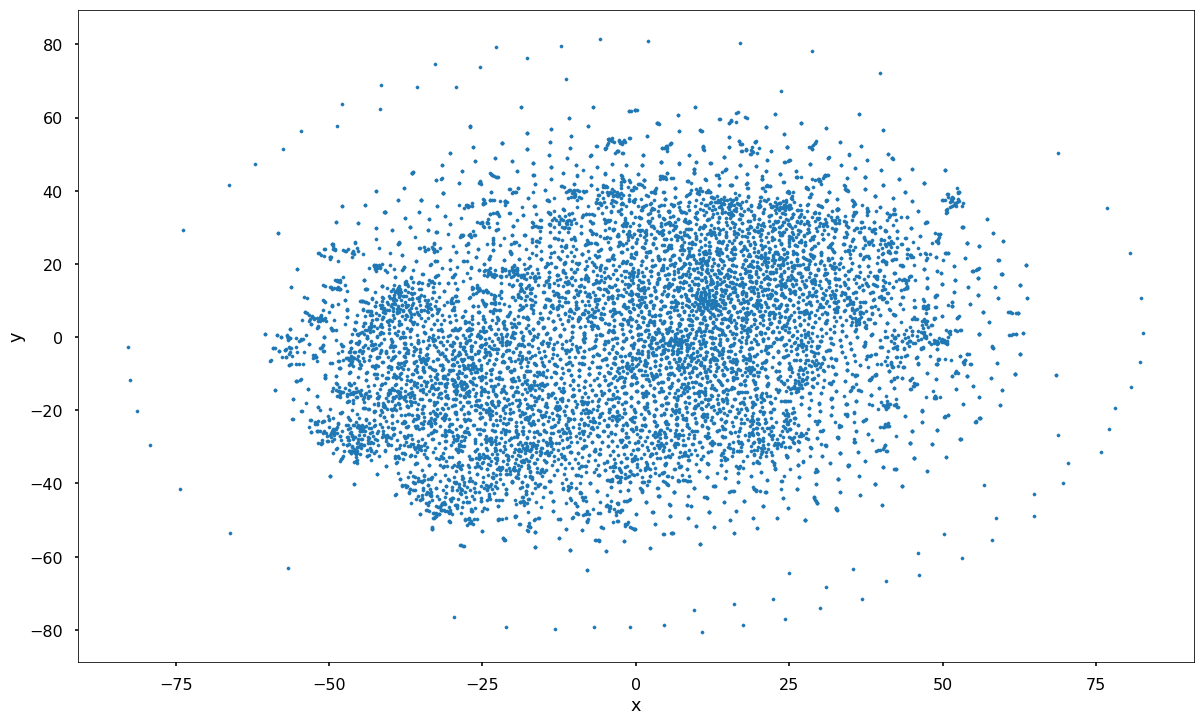

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

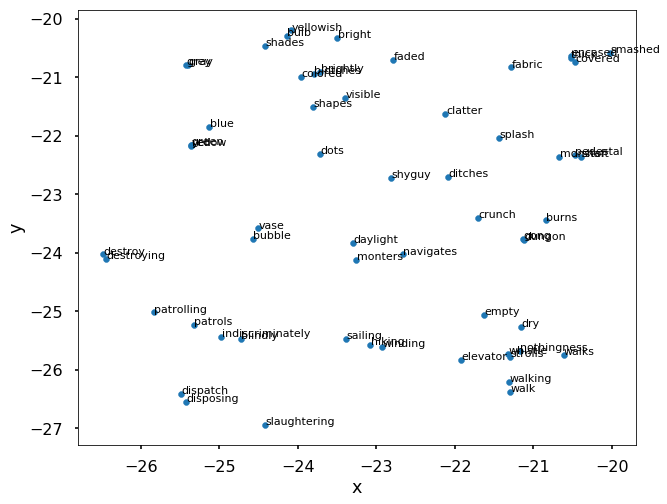

In [19]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
     
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
 
plot_region(x_bounds=(-27, -20), y_bounds=(-27, -20))

In [20]:
w2v_model.most_similar("playstation")

/home/m.victor.le/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ps', 0.7762706875801086),
 ('playstaion', 0.6817536354064941),
 ('playsation', 0.6323065757751465),
 ('playstion', 0.621810257434845),
 ('psone', 0.6132895946502686),
 ('gamecubes', 0.6046957969665527),
 ('theplaystation', 0.6011494398117065),
 ('psp', 0.5878587961196899),
 ('playstationthis', 0.583646297454834),
 ('psn', 0.5828137397766113)]

In [22]:
w2v_model.most_similar("mario")

/home/m.victor.le/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bros', 0.7756750583648682),
 ('kart', 0.7373790740966797),
 ('luigi', 0.685077965259552),
 ('smb', 0.6706875562667847),
 ('sunshine', 0.6583332419395447),
 ('nsmb', 0.6517567038536072),
 ('wiimario', 0.6485967040061951),
 ('yoshi', 0.6413971185684204),
 ('sluggers', 0.6400899291038513),
 ('ssbb', 0.6217820644378662)]

### Grid search

In [28]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)


# Set the parameters by cross-validation
tuned_parameters = [{'classifier__kernel': ['rbf'], 'classifier__gamma': [1e-3, 1e-4],
                     'classifier__C': [1, 10, 100, 1000]},
                    {'classifier__kernel': ['linear'], 'classifier__C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(create_pipeline(classifier=SVC()), tuned_parameters, cv=5,
                       scoring='%s_macro' % score, verbose=2, n_jobs=32)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] classifier__C=1, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.0001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.0001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.0001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.0001, classifier__kernel=rbf 
[CV] classifier__C=1, classifier__gamma=0.0001, classifier__kernel=rbf 
[CV] classifier__C=10, classifier__gamma=0.001, classifier__kernel=rbf 
[CV] classifier__C=10, classifier__gamma=0.001, class

[Parallel(n_jobs=32)]: Done  28 out of  60 | elapsed:   55.1s remaining:  1.1min


[CV]  classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf, total=  29.6s
[CV]  classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, total=  29.3s
[CV]  classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, total=  31.2s
[CV]  classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf, total=  30.6s
[CV]  classifier__C=1000, classifier__gamma=0.0001, classifier__kernel=rbf, total=  24.3s
[CV]  classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, total=  25.2s
[CV]  classifier__C=1000, classifier__gamma=0.0001, classifier__kernel=rbf, total=  26.3s
[CV]  classifier__C=1000, classifier__gamma=0.0001, classifier__kernel=rbf, total=  25.3s
[CV]  classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, total=  26.4s
[CV]  classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, total=  28.0s
[CV]  classifier__C=1000, classifier__gamma=0.0001, classifier__kernel=rbf, total=  24.9s
[CV]  classifier__

[Parallel(n_jobs=32)]: Done  60 out of  60 | elapsed: 303.2min finished


Best parameters set found on development set:

{'classifier__C': 1, 'classifier__kernel': 'linear'}

Grid scores on development set:

0.507 (+/-0.072) for {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.433 (+/-0.048) for {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.529 (+/-0.052) for {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.492 (+/-0.083) for {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.515 (+/-0.074) for {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.504 (+/-0.070) for {'classifier__C': 100, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.512 (+/-0.074) for {'classifier__C': 1000, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.513 (+/-0.061) for {'classifier__C': 1000, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.555 (+/-0.072) for {'classifier__C': 1, 'classifier__ker

### Evaluate model

In [43]:
train_accs = []
test_accs = []
steps = 10
for i in range(int(len(X_train) / steps), len(X_train), int(len(X_train) / steps)):
    model = create_pipeline(classifier=SVC(kernel='linear'))
    model.fit(X_train[:i], y_train[:i])
    
    y_pred = model.predict(X_train[:i])
    train_acc = accuracy_score(y_train[:i], y_pred)
    train_accs.append(train_acc)
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_accs.append(test_acc)
    print(test_acc)

0.401315789474
0.467105263158
0.644736842105
0.631578947368
0.625
0.638157894737
0.631578947368
0.625
0.638157894737
0.638157894737
0.651315789474
0.631578947368
0.625
0.572368421053
0.605263157895
0.598684210526
0.526315789474
0.546052631579
0.447368421053
0.572368421053
0.486842105263
0.539473684211
0.526315789474
0.388157894737
0.388157894737
0.381578947368
0.421052631579
0.375
0.407894736842
0.421052631579
0.421052631579
0.394736842105
0.375
0.414473684211
0.414473684211
0.427631578947
0.421052631579
0.447368421053
0.546052631579
0.394736842105
0.394736842105
0.401315789474
0.414473684211
0.434210526316
0.447368421053
0.414473684211
0.421052631579
0.421052631579
0.414473684211
0.453947368421
0.434210526316
0.427631578947
0.434210526316
0.460526315789
0.473684210526
0.460526315789
0.480263157895
0.559210526316
0.473684210526
0.460526315789
0.5
0.486842105263
0.460526315789
0.493421052632
0.447368421053
0.467105263158
0.447368421053
0.473684210526
0.447368421053
0.427631578947
0.4078

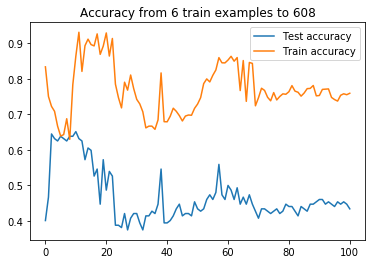

In [50]:
plt.plot(test_accs, label="Test accuracy")
plt.plot(train_accs, label="Train accuracy")
plt.title('Accuracy from '+ str(int(len(X_train) / steps)) + ' train examples to ' + str(len(X_train)))
plt.legend();